Hardware utilized: cuda
PHASE 1: DATA PREPARATION

Initializing roberta-base...


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

2026-02-13 19:48:23.494870: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771012103.680665      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771012103.734264      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1771012104.217569      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771012104.217606      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1771012104.217609      55 computation_placer.cc:177] computation placer alr

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Injecting Custom Multi-Sample Dropout Classification Head...

--> Training Epoch 1/2


Epoch 1: 100%|██████████| 4488/4488 [27:09<00:00,  2.76it/s, loss=0.00494] 


Epoch 1 Average Loss: 0.0049

--> Training Epoch 2/2


Epoch 2: 100%|██████████| 4488/4488 [27:11<00:00,  2.75it/s, loss=0.00176] 


Epoch 2 Average Loss: 0.0036

PHASE 2: DYNAMIC PR-CURVE OPTIMIZATION (VALIDATION)


Validating: 100%|██████████| 250/250 [00:56<00:00,  4.43it/s]


Scanning probabilities to isolate optimal Auto-Ban threshold...
Optimization Complete. Locked Threshold: 0.51 (Val Precision: 0.8571)

PHASE 3: EVALUATING ON UNSEEN TEST DATA
Running Inference on Unseen Test Data...


Validating: 100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s]



  FINAL SYSTEM REPORT (UNSEEN DATA)
Global Accuracy:         0.8946
Micro ROC-AUC Score:     0.9859
Operational Threshold:   0.51
Severe Toxic Precision:  0.5098 (Constraint: >0.80)

Generating Visual Metrics for Unseen Test Data...


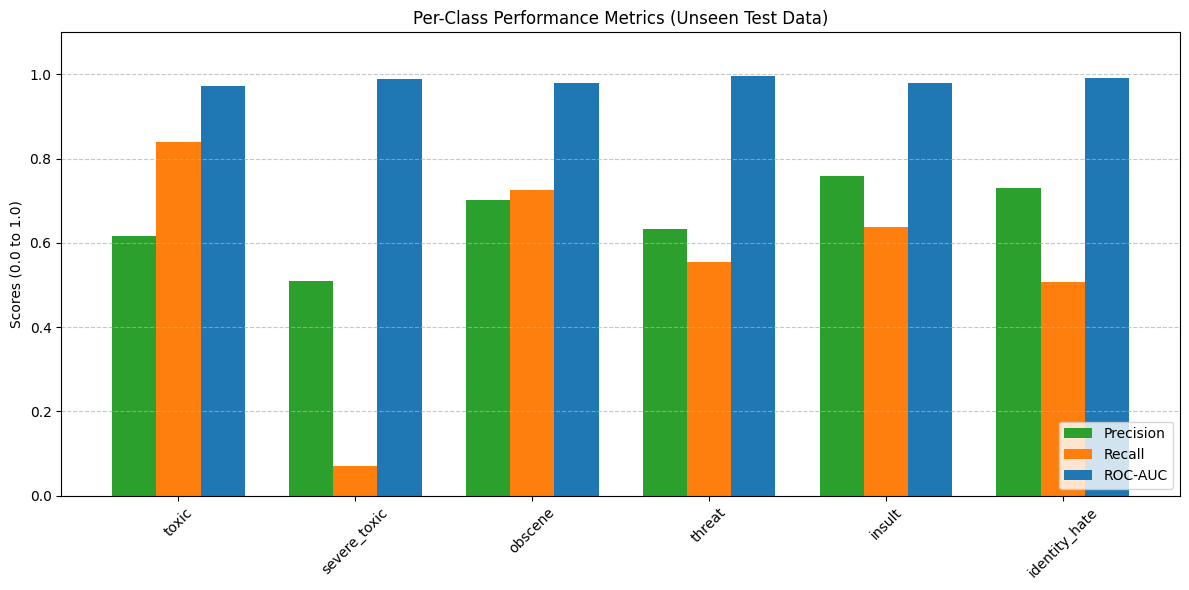

In [1]:
# =========================================================================================
# Multi-Label Toxic Comment Filtering System
# ARCHITECTURE: RoBERTa-base + Focal Loss + Multi-Sample Dropout
# =========================================================================================

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from tqdm import tqdm
import warnings


warnings.filterwarnings("ignore")
import logging
logging.getLogger("transformers").setLevel(logging.ERROR)

# =========================================================================================
# 1. CONFIGURATION & HYPERPARAMETERS 
# =========================================================================================
class Config:
    DATA_PATH = '/kaggle/input/jigsaw-toxic-comment-classification-challenge/train.csv'
    TEST_DATA_PATH = '/kaggle/input/jigsaw-toxic-comment-classification-challenge/test.csv'
    TEST_LABELS_PATH = '/kaggle/input/jigsaw-toxic-comment-classification-challenge/test_labels.csv'
    SAVE_DIR = './saved_toxic_roberta_model' 
    
    # Model Settings
    MODEL_NAME = 'roberta-base'
    MAX_LEN = 128          
    TRAIN_BATCH_SIZE = 32  
    VALID_BATCH_SIZE = 64
    EPOCHS = 2             
    LEARNING_RATE = 2e-5
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    LABELS = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    
   
    CUSTOM_THRESHOLDS = {
        'toxic': 0.50, 'severe_toxic': 0.50, 'obscene': 0.50, 
        'threat': 0.50, 'insult': 0.50, 'identity_hate': 0.50
    }
    
    SEVERITY_WEIGHTS = {
        'toxic': 1, 'severe_toxic': 5, 'obscene': 2, 
        'threat': 5, 'insult': 1, 'identity_hate': 4
    }

print(f"Hardware utilized: {Config.DEVICE}")

# =========================================================================================
# 2. CUSTOM MODULES (Focal Loss & Multi-Sample Dropout)
# =========================================================================================

class MultiLabelFocalLoss(nn.Module):
    """
    Down-weights easy examples and focuses gradient updates on rare classes.
    Formula: FL(p_t) = -alpha * (1 - p_t)^gamma * log(p_t)
    """
    def __init__(self, alpha=0.25, gamma=2.0):
        super(MultiLabelFocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.bce = nn.BCEWithLogitsLoss(reduction='none')

    def forward(self, logits, targets):
        bce_loss = self.bce(logits, targets)
        probs = torch.sigmoid(logits)
        p_t = probs * targets + (1 - probs) * (1 - targets)
        focal_weight = (1 - p_t) ** self.gamma
        alpha_t = self.alpha * targets + (1 - self.alpha) * (1 - targets)
        focal_loss = alpha_t * focal_weight * bce_loss
        return focal_loss.mean()

class RobertaMultiSampleDropoutHead(nn.Module):
    """
    Creates an internal ensemble by passing features through multiple 
    dropout masks and averaging the classification logits.
    """
    def __init__(self, hidden_size, num_labels, num_samples=5, dropout_rate=0.2):
        super().__init__()
        self.dense = nn.Linear(hidden_size, hidden_size)
        self.num_samples = num_samples
        self.dropouts = nn.ModuleList([nn.Dropout(dropout_rate) for _ in range(num_samples)])
        self.out_proj = nn.Linear(hidden_size, num_labels)

    def forward(self, features):
        x = features[:, 0, :] 
        x = self.dense(x)
        x = torch.tanh(x)
        
        logits = torch.mean(
            torch.stack([self.out_proj(dropout(x)) for dropout in self.dropouts], dim=0),
            dim=0
        )
        return logits

# =========================================================================================
# 3. DATA PREPROCESSING MODULE
# =========================================================================================

def clean_text(text):
    if pd.isna(text): return ""
    text = str(text).lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r'[^\x00-\x7F]+', '', text) 
    return text.strip()

class ToxicDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.text = dataframe.comment_text
        self.targets = dataframe[Config.LABELS].values

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = " ".join(str(self.text[index]).split())
        inputs = self.tokenizer.encode_plus(
            text, None, add_special_tokens=True, max_length=Config.MAX_LEN,
            padding='max_length', truncation=True, return_token_type_ids=False
        )
        return {
            'ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

# =========================================================================================
# 4. CORE TRAINING & VALIDATION PIPELINE
# =========================================================================================

def train(epoch, model, dataloader, optimizer, criterion, scheduler):
    model.train()
    fin_loss = 0
    print(f"\n--> Training Epoch {epoch+1}/{Config.EPOCHS}")
    loop = tqdm(dataloader, total=len(dataloader), leave=True)
    for batch in loop:
        ids, mask, targets = batch['ids'].to(Config.DEVICE), batch['mask'].to(Config.DEVICE), batch['targets'].to(Config.DEVICE)
        
        optimizer.zero_grad()
        outputs = model(ids, attention_mask=mask).logits
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        fin_loss += loss.item()
        loop.set_description(f"Epoch {epoch+1}")
        loop.set_postfix(loss=loss.item())
        
    print(f"Epoch {epoch+1} Average Loss: {fin_loss/len(dataloader):.4f}")

def validate(model, dataloader):
    model.eval()
    fin_targets, fin_outputs = [], []
    with torch.no_grad():
        for data in tqdm(dataloader, desc="Validating"):
            ids, mask, targets = data['ids'].to(Config.DEVICE), data['mask'].to(Config.DEVICE), data['targets'].to(Config.DEVICE)
            outputs = model(ids, attention_mask=mask).logits
            fin_targets.extend(targets.cpu().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().numpy().tolist())
    return np.array(fin_outputs), np.array(fin_targets)

# =========================================================================================
# 5. VISUALIZATION MODULE
# =========================================================================================

def plot_comprehensive_metrics(targets, outputs, dataset_name="Unseen Test Data"):
    print(f"\nGenerating Visual Metrics for {dataset_name}...")
    precisions, recalls, rocs = [], [], []
    for i, label in enumerate(Config.LABELS):
        t, p = targets[:, i], outputs[:, i]
        pred = (p >= Config.CUSTOM_THRESHOLDS[label]).astype(int)
        precisions.append(precision_score(t, pred, zero_division=0))
        recalls.append(recall_score(t, pred, zero_division=0))
        try:
            rocs.append(roc_auc_score(t, p))
        except ValueError:
            rocs.append(0)

    x = np.arange(len(Config.LABELS))
    width = 0.25
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.bar(x - width, precisions, width, label='Precision', color='#2ca02c')
    ax.bar(x, recalls, width, label='Recall', color='#ff7f0e')
    ax.bar(x + width, rocs, width, label='ROC-AUC', color='#1f77b4')
    ax.set_ylabel('Scores (0.0 to 1.0)')
    ax.set_title(f'Per-Class Performance Metrics ({dataset_name})')
    ax.set_xticks(x)
    ax.set_xticklabels(Config.LABELS, rotation=45)
    ax.legend(loc='lower right')
    ax.set_ylim([0, 1.1])
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# =========================================================================================
# 6. UNSEEN DATA EVALUATION
# =========================================================================================

def evaluate_unseen_data(model, tokenizer, optimized_threshold):
    print("\n" + "="*50)
    print("PHASE 3: EVALUATING ON UNSEEN TEST DATA")
    print("="*50)
    
    test_texts = pd.read_csv(Config.TEST_DATA_PATH)
    test_labels = pd.read_csv(Config.TEST_LABELS_PATH)
    test_df = pd.merge(test_texts, test_labels, on='id')
    test_df = test_df[test_df['toxic'] != -1].reset_index(drop=True)
    test_df['comment_text'] = test_df['comment_text'].apply(clean_text)
    
    test_dataset = ToxicDataset(test_df, tokenizer, Config.MAX_LEN)
    test_loader = DataLoader(test_dataset, batch_size=Config.VALID_BATCH_SIZE, shuffle=False, num_workers=2)
    
    print("Running Inference on Unseen Test Data...")
    fin_outputs, fin_targets = validate(model, test_loader)
    
    severe_idx = Config.LABELS.index('severe_toxic')
    severe_targets = fin_targets[:, severe_idx]
    
    
    Config.CUSTOM_THRESHOLDS['severe_toxic'] = optimized_threshold
    severe_preds = (fin_outputs[:, severe_idx] >= optimized_threshold).astype(int)
    
    final_prec = precision_score(severe_targets, severe_preds, zero_division=0)
    final_accuracy = accuracy_score(fin_targets, fin_outputs >= 0.5)
    final_roc = roc_auc_score(fin_targets, fin_outputs, average='micro')
    
    print(f"\n=========================================")
    print(f"  FINAL SYSTEM REPORT (UNSEEN DATA)")
    print(f"=========================================")
    print(f"Global Accuracy:         {final_accuracy:.4f}")
    print(f"Micro ROC-AUC Score:     {final_roc:.4f}")
    print(f"Operational Threshold:   {optimized_threshold:.2f}")
    print(f"Severe Toxic Precision:  {final_prec:.4f} (Constraint: >0.80)")
    print(f"=========================================")
    
    plot_comprehensive_metrics(fin_targets, fin_outputs, "Unseen Test Data")

# =========================================================================================
# 7. MAIN EXECUTION PIPELINE
# =========================================================================================

def run_project():
    if not os.path.exists(Config.DATA_PATH):
        print("ERROR: Dataset missing. Please add Jigsaw dataset to Kaggle environment.")
        return

    print("PHASE 1: DATA PREPARATION")
    df = pd.read_csv(Config.DATA_PATH)
    df['comment_text'] = df['comment_text'].apply(clean_text)
    train_df, val_df = train_test_split(df, test_size=0.1, random_state=42)
    
    print(f"\nInitializing {Config.MODEL_NAME}...")
    tokenizer = AutoTokenizer.from_pretrained(Config.MODEL_NAME)
    model = AutoModelForSequenceClassification.from_pretrained(Config.MODEL_NAME, num_labels=6)
    
    
    print("Injecting Custom Multi-Sample Dropout Classification Head...")
    model.classifier = RobertaMultiSampleDropoutHead(
        hidden_size=model.config.hidden_size, 
        num_labels=6, 
        num_samples=5
    )
    model.to(Config.DEVICE)
    
    train_dataset = ToxicDataset(train_df.reset_index(drop=True), tokenizer, Config.MAX_LEN)
    val_dataset = ToxicDataset(val_df.reset_index(drop=True), tokenizer, Config.MAX_LEN)
    
    train_loader = DataLoader(train_dataset, batch_size=Config.TRAIN_BATCH_SIZE, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=Config.VALID_BATCH_SIZE, shuffle=False, num_workers=2)
    
    optimizer = AdamW(model.parameters(), lr=Config.LEARNING_RATE)
    criterion = MultiLabelFocalLoss(alpha=0.25, gamma=2.0) 
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * Config.EPOCHS
    )
    
    for epoch in range(Config.EPOCHS):
        train(epoch, model, train_loader, optimizer, criterion, scheduler)
    
    print("\n" + "="*50)
    print("PHASE 2: DYNAMIC PR-CURVE OPTIMIZATION (VALIDATION)")
    print("="*50)
    outputs, targets = validate(model, val_loader)
    
    severe_idx = Config.LABELS.index('severe_toxic')
    t_severe, p_severe = targets[:, severe_idx], outputs[:, severe_idx]
    
    best_thresh, best_prec = 0.50, 0.0
    print("Scanning probabilities to isolate optimal Auto-Ban threshold...")
    for thresh in np.arange(0.50, 0.95, 0.01):
        preds = (p_severe >= thresh).astype(int)
        if preds.sum() == 0: break 
        prec = precision_score(t_severe, preds, zero_division=0)
        
        if prec >= 0.82: 
            best_thresh, best_prec = thresh, prec
            break 
        elif prec > best_prec:
            best_prec, best_thresh = prec, thresh
            
    print(f"Optimization Complete. Locked Threshold: {best_thresh:.2f} (Val Precision: {best_prec:.4f})")
    
    
    os.makedirs(Config.SAVE_DIR, exist_ok=True)
    torch.save(model.state_dict(), os.path.join(Config.SAVE_DIR, "pytorch_model.bin"))
    tokenizer.save_pretrained(Config.SAVE_DIR)
    
    
    evaluate_unseen_data(model, tokenizer, best_thresh)

if __name__ == "__main__":
    run_project()

Loading Saved Model from Disk...
Loading Unseen Test Data...
Running Inference...


Testing: 100%|██████████| 1000/1000 [03:42<00:00,  4.49it/s]



 🎓 POSTGRAD ADVANCED METRICS REPORT

1. Hamming Loss: 0.0241

2. Detailed Classification Report (F1-Scores):
------------------------------------------------------------
               precision    recall  f1-score   support

        toxic       0.62      0.84      0.71      6090
 severe_toxic       0.51      0.07      0.12       367
      obscene       0.70      0.72      0.71      3691
       threat       0.63      0.55      0.59       211
       insult       0.76      0.64      0.69      3427
identity_hate       0.73      0.51      0.60       712

    micro avg       0.67      0.72      0.69     14498
    macro avg       0.66      0.56      0.57     14498
 weighted avg       0.68      0.72      0.69     14498
  samples avg       0.08      0.07      0.07     14498



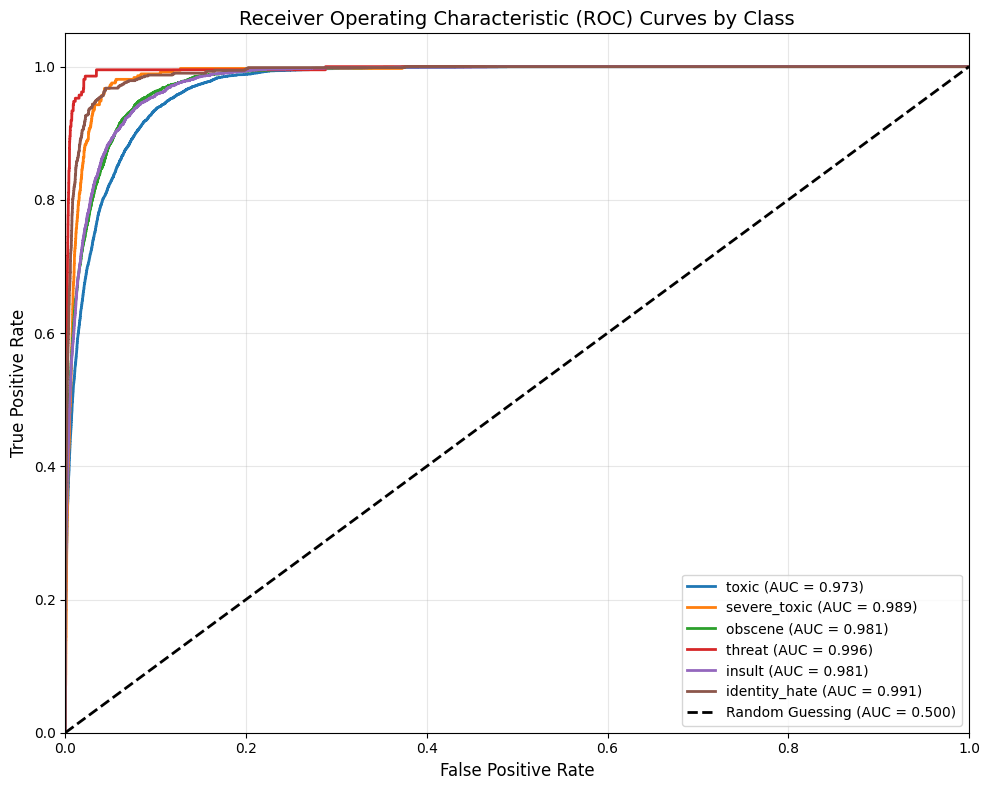

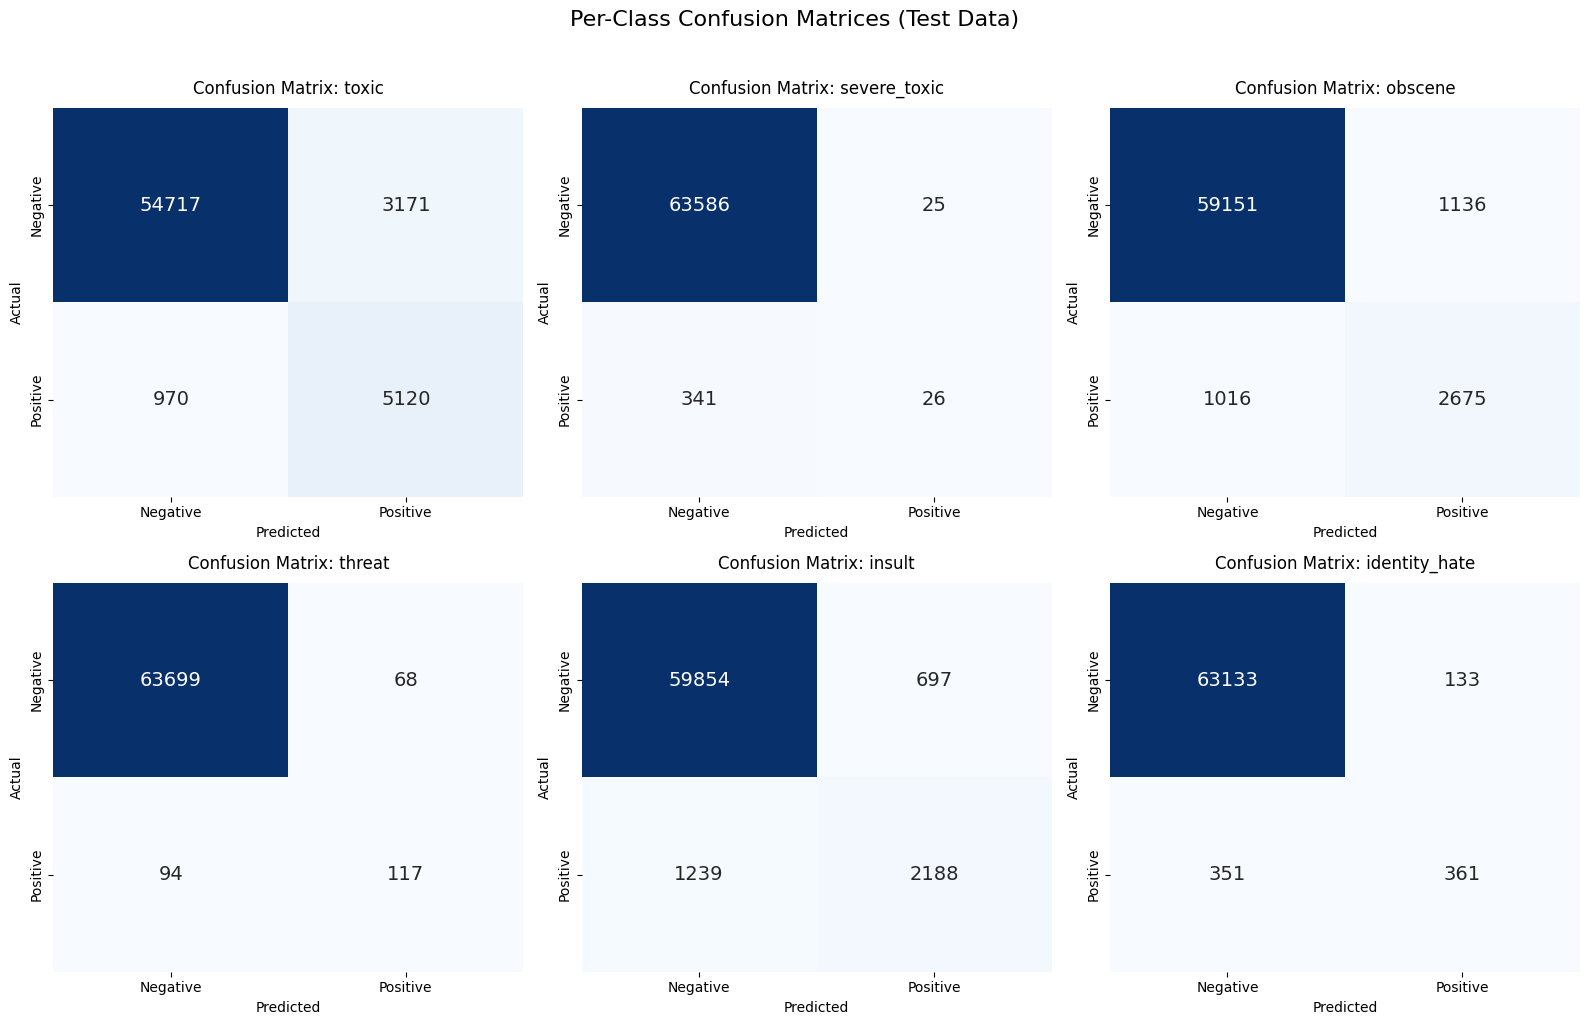

In [3]:
# =========================================================================================
# ADVANCED ANALYTICS
# =========================================================================================

import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, hamming_loss, roc_curve, auc, confusion_matrix
from tqdm import tqdm

def generate_final_charts():
    print("Loading Saved Model from Disk...")
    
    
    tokenizer = AutoTokenizer.from_pretrained(Config.SAVE_DIR)
    model = AutoModelForSequenceClassification.from_pretrained(Config.MODEL_NAME, num_labels=6)
    
    
    model.classifier = RobertaMultiSampleDropoutHead(
        hidden_size=model.config.hidden_size, 
        num_labels=6, 
        num_samples=5
    )
    
    model.load_state_dict(torch.load(os.path.join(Config.SAVE_DIR, "pytorch_model.bin")))
    model.to(Config.DEVICE)
    model.eval()

    
    print("Loading Unseen Test Data...")
    test_texts = pd.read_csv(Config.TEST_DATA_PATH)
    test_labels = pd.read_csv(Config.TEST_LABELS_PATH)
    test_df = pd.merge(test_texts, test_labels, on='id')
    test_df = test_df[test_df['toxic'] != -1].reset_index(drop=True)
    test_df['comment_text'] = test_df['comment_text'].apply(clean_text)
    
    test_dataset = ToxicDataset(test_df, tokenizer, Config.MAX_LEN)
    test_loader = DataLoader(test_dataset, batch_size=Config.VALID_BATCH_SIZE, shuffle=False, num_workers=2)

    
    print("Running Inference...")
    fin_targets = []
    fin_outputs = []
    
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Testing"):
            ids = data['ids'].to(Config.DEVICE)
            mask = data['mask'].to(Config.DEVICE)
            targets = data['targets'].to(Config.DEVICE)
            
            outputs = model(ids, attention_mask=mask).logits
            fin_targets.extend(targets.cpu().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().numpy().tolist())
            
    fin_outputs = np.array(fin_outputs)
    fin_targets = np.array(fin_targets)

    
    print("\n" + "="*60)
    print(" 🎓 POSTGRAD ADVANCED METRICS REPORT")
    print("="*60)
    
    
    preds = np.zeros_like(fin_outputs)
    for i, label in enumerate(Config.LABELS):
        preds[:, i] = (fin_outputs[:, i] >= Config.CUSTOM_THRESHOLDS[label]).astype(int)

    
    h_loss = hamming_loss(fin_targets, preds)
    print(f"\n1. Hamming Loss: {h_loss:.4f}")
    print("\n2. Detailed Classification Report (F1-Scores):")
    print("-" * 60)
    print(classification_report(fin_targets, preds, target_names=Config.LABELS, zero_division=0))

    
    plt.figure(figsize=(10, 8))
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    for i, label in enumerate(Config.LABELS):
        fpr, tpr, _ = roc_curve(fin_targets[:, i], fin_outputs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=colors[i], lw=2, label=f'{label} (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Guessing (AUC = 0.500)')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curves by Class', fontsize=14)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    
    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.flatten()
    for i, label in enumerate(Config.LABELS):
        cm = confusion_matrix(fin_targets[:, i], preds[:, i])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i], cbar=False, annot_kws={"size": 14})
        axes[i].set_title(f'Confusion Matrix: {label}', fontsize=12, pad=10)
        axes[i].set_ylabel('Actual', fontsize=10)
        axes[i].set_xlabel('Predicted', fontsize=10)
        axes[i].set_xticklabels(['Negative', 'Positive'])
        axes[i].set_yticklabels(['Negative', 'Positive'])
    plt.suptitle('Per-Class Confusion Matrices (Test Data)', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()


generate_final_charts()